# Fig 4: oscillation bursts gif

This notebook creates an animated visualizer showing how oscillatory burstiness can influence estimates.

Based on Fig 4 (d-f) of the oscillation methods paper.

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_powerlaw, sim_bursty_oscillation

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
# Import custom code
from code.plts import plot_bar, plot_timeseries, plot_spectra
from code.gif import clear_output, _gif_plot_output
from code.measures import compute_abs_power

## SETTINGS

In [4]:
# Simulation settings
n_seconds = 100
fs = 1000

cf = 10
exp = -1.0
ap_filt = (3, 50)

In [5]:
# Define a list of burst properties to loop over
burst_params = [
    
    # Continuous oscillation (no burst), amplitude difference
    [{'n_cycles_burst' : 1, 'n_cycles_off' : 0, 'variance' : 0.1},
     {'n_cycles_burst' : 1, 'n_cycles_off' : 0, 'variance' : 0.3}], 

    # Change in burst duration
    [{'n_cycles_burst' : 3, 'n_cycles_off' : 6, 'variance' : 1},
     {'n_cycles_burst' : 5, 'n_cycles_off' : 4, 'variance' : 1}], 
    
    # Change in burst occurence
    [{'n_cycles_burst' : 3, 'n_cycles_off' : 11, 'variance' : 1},
     {'n_cycles_burst' : 3, 'n_cycles_off' : 4, 'variance' : 1}], 
    
    # Change in burst amplitude
    [{'n_cycles_burst' : 3, 'n_cycles_off' : 6, 'variance' : 1.},
     {'n_cycles_burst' : 3, 'n_cycles_off' : 6, 'variance' : 1.8}], 
]

In [6]:
# Define band ranges
alpha_range = [8, 12]
alpha_color = '#1882d9'

In [7]:
# Plot settings
colors = ['#0000ff', '#00693a']
alpha = 0.8

xlim = [2550, 5300]

In [8]:
# Set whether to save out
SAVE = False

## DEFINE AXES

In [9]:
def make_axes():
    
    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(2, 5)

    ax1 = fig.add_subplot(gs[0, 0:3])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[0:, 3:])
    
    return fig, ax1, ax2, ax3, ax4, ax5

## SIMULATE SIGNAL

In [10]:
# Create the aperiodic component to use
ap = sim_powerlaw(n_seconds, fs, exp, variance=0.1)

In [11]:
# Simulate combined signals 
ind = 3

bp1 = deepcopy(burst_params[ind][0])
var1 = bp1.pop('variance')
bursts1 = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', bp1, variance=var1)
bursts1 = ap + bursts1

bp2 = deepcopy(burst_params[ind][1])
var2 = bp2.pop('variance')
bursts2 = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', bp2, variance=var2)
bursts2 = ap + bursts2

In [12]:
# Compute power spectra of bursts and difference in alpha
freqs1, powers1 = compute_spectrum(bursts1, fs)
freqs2, powers2 = compute_spectrum(bursts2, fs)

alpha_diff = compute_abs_power(freqs1, powers1, alpha_range) - \
    compute_abs_power(freqs2, powers2, alpha_range)

## EXAMPLE PLOT

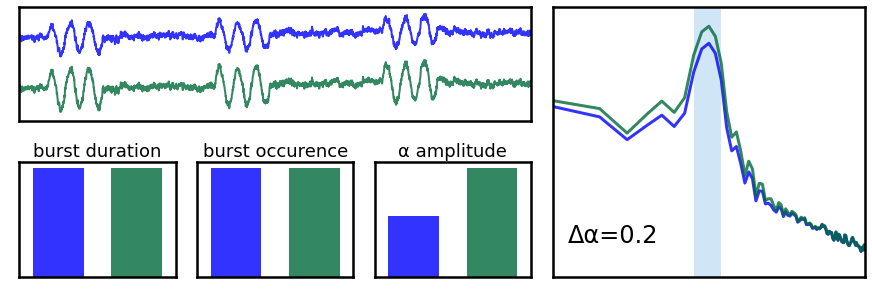

In [13]:
# Create an example panel of the visualizer
fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
plot_timeseries([bursts1, bursts2], xlim=xlim,
                colors=colors, alpha=alpha, offset=-5, lw=2, ax=ax1)
plot_bar(bp1['n_cycles_burst'], bp2['n_cycles_burst'],
         title='burst duration', color=colors, alpha=alpha, ax=ax2)
plot_bar(bp1['n_cycles_burst'] + bp1['n_cycles_off'],
         bp2['n_cycles_burst'] + bp2['n_cycles_off'],
         title='burst occurence', color=colors, alpha=alpha, ax=ax3)
plot_bar(var1, var2, title='α amplitude', 
         color=colors, alpha=alpha, ax=ax4)
plot_spectra(freqs1, [powers1, powers2], colors=colors, 
             shade_ranges=[alpha_range], shade_colors=[alpha_color],
             alpha=alpha, xlim=[0, 2.], ylim=[-4.5, -0.5], ax=ax5)
ax5.text(0.1, -4, 'Δα={:2.1f}'.format(np.abs(alpha_diff)), fontdict={'fontweight' : 16});

## BUILDER FUNCTIONS

In [14]:
def build_all(burst_params, sleep=2, save=False):
    
    ## Create builds
    for b_ind, params in enumerate(burst_params):
        
        clear_output(wait=True)
        
        ## Setup
        bp1 = deepcopy(params[0])
        var1 = bp1.pop('variance')
        bursts1 = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', bp1, variance=var1)
        bursts1 = ap + bursts1

        bp2 = deepcopy(params[1])
        var2 = bp2.pop('variance')
        bursts2 = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', bp2, variance=var2)
        bursts2 = ap + bursts2
        
        freqs1, powers1 = compute_spectrum(bursts1, fs)
        freqs2, powers2 = compute_spectrum(bursts2, fs)
        alpha_diff = compute_abs_power(freqs1, powers1, alpha_range) - \
            compute_abs_power(freqs2, powers2, alpha_range)
        
        ## Make plot
        fig, ax1, ax2, ax3, ax4, ax5 = make_axes()
        plot_timeseries([bursts1, bursts2], xlim=xlim,
                        colors=colors, alpha=alpha, offset=-5, lw=2, ax=ax1)
        plot_bar(bp1['n_cycles_burst'], bp2['n_cycles_burst'], 
                 title='burst duration', color=colors, alpha=alpha, ax=ax2)
        plot_bar(bp1['n_cycles_burst'] + bp1['n_cycles_off'],
                 bp2['n_cycles_burst'] + bp2['n_cycles_off'],
                 title='burst occurence', color=colors, alpha=alpha, ax=ax3)
        plot_bar(var1, var2, title='osc amplitude', color=colors, alpha=alpha, ax=ax4)
        plot_spectra(freqs1, [powers1, powers2], colors=colors, 
                     shade_ranges=[alpha_range], shade_colors=[alpha_color],
                     alpha=alpha, xlim=[0, 2.], ylim=[-4.5, -0.5], ax=ax5)
        ax5.text(0.1, -4, 'Δα={:2.1f}'.format(alpha_diff), fontdict={'fontweight' : 16})
    
        _gif_plot_output(fig, save, b_ind, 'fig4', sleep)

## ANIMATED PLOT

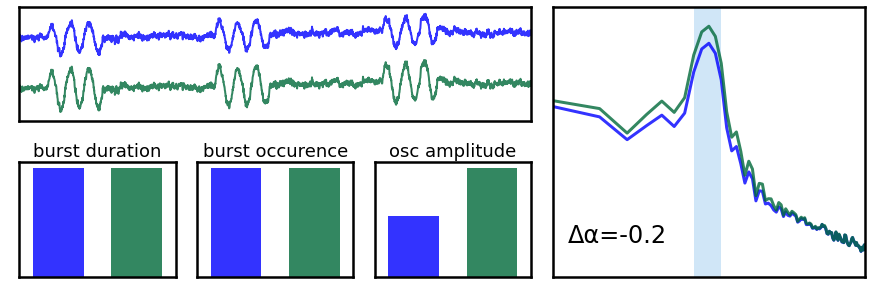

In [15]:
# Create the animated plot
build_all(burst_params, save=SAVE)